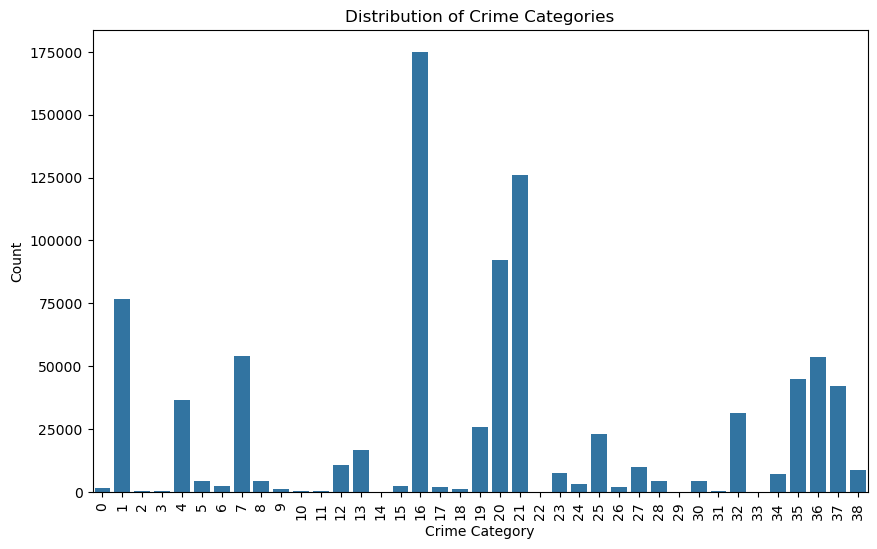

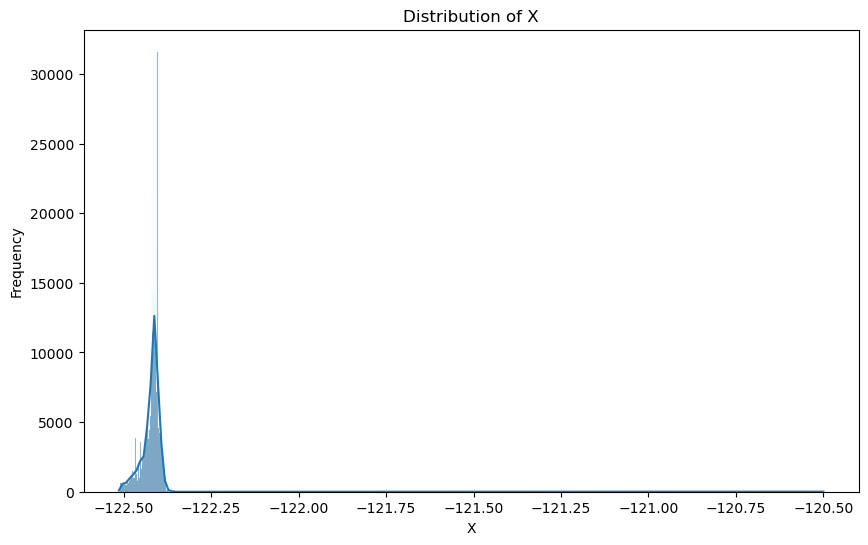

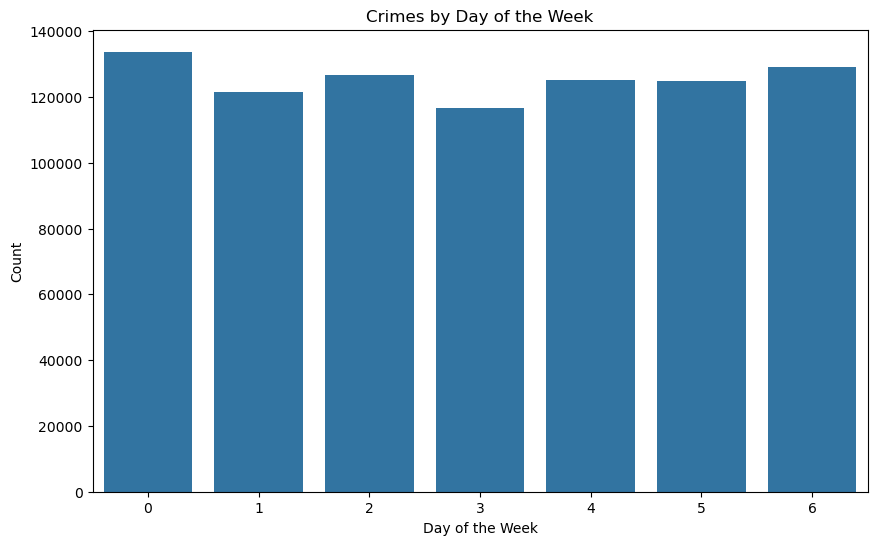

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

class ModifiedLabelEncoder(LabelEncoder):
    """Custom Label Encoder to handle unseen labels by assigning them to '<unseen>' category."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.classes_ = None

    def fit(self, y):
        super().fit(y)
        self.classes_ = np.append(self.classes_, '<unseen>')

    def transform(self, y):
        new_y = np.array([item if item in self.classes_ else '<unseen>' for item in y])
        return super().transform(new_y)

# Load data
train = pd.read_csv('Data/sf-crime/train.csv')
test = pd.read_csv('Data/sf-crime/test.csv')

# Check and handle the date column
date_column = 'Date' if 'Date' in train.columns else 'Dates' if 'Dates' in train.columns else None

if date_column:
    train[date_column] = pd.to_datetime(train[date_column])
    test[date_column] = pd.to_datetime(test[date_column])

    # Extract day of week
    train['DayOfWeek'] = train[date_column].dt.day_name()
    test['DayOfWeek'] = test[date_column].dt.day_name()

    # Extract other components as needed
    train['Year'] = train[date_column].dt.year
    train['Month'] = train[date_column].dt.month
    train['Day'] = train[date_column].dt.day
    train['Hour'] = train[date_column].dt.hour

    test['Year'] = test[date_column].dt.year
    test['Month'] = test[date_column].dt.month
    test['Day'] = test[date_column].dt.day
    test['Hour'] = test[date_column].dt.hour

# Encode categorical variables
for column in ['DayOfWeek', 'PdDistrict']:
    le = LabelEncoder()
    train[column] = le.fit_transform(train[column])
    test[column] = le.transform(test[column])

# Encode the 'Category' with ModifiedLabelEncoder
category_encoder = ModifiedLabelEncoder()
train['Category'] = category_encoder.fit_transform(train['Category'])

# Exploratory Data Analysis (EDA)
# 1. Target Variable Analysis
plt.figure(figsize=(10, 6))
sns.countplot(x='Category', data=train)
plt.xticks(rotation=90)
plt.title('Distribution of Crime Categories')
plt.xlabel('Crime Category')
plt.ylabel('Count')
plt.show()

# 2. Analyze Numerical Features
# Assuming 'X' contains numerical features
plt.figure(figsize=(10, 6))
sns.histplot(x='X', data=train, kde=True) 
plt.title('Distribution of X')
plt.xlabel('X')
plt.ylabel('Frequency')
plt.show()

# 3. Analyze Categorical Features
plt.figure(figsize=(10, 6))
sns.countplot(x='DayOfWeek', data=train)
plt.title('Crimes by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.show()

# 4. Correlation Analysis (if applicable)
# If you have numerical features, you can analyze correlations
# plt.figure(figsize=(10, 8))
# sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()

# Prepare data for modeling
X = train.drop(['Category', 'Descript', 'Resolution', date_column, 'Address'], axis=1, errors='ignore')
y = train['Category']
X_test = test.drop(['Id', date_column, 'Address'], axis=1, errors='ignore')

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_pca = pca.fit_transform(X_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Split data after PCA
X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size=0.2, random_state=42)


# RandomForestClassifier

In [2]:
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict_proba(X_val)
print(f'Random Forest Log Loss: {log_loss(y_val, y_pred_rf)}')

Random Forest Log Loss: 7.029437283573975


In [3]:
predictions_rf = rf.predict_proba(X_test)

In [4]:
submission_rf = pd.DataFrame(predictions_rf, columns=category_encoder.classes_)
submission_rf.insert(0, 'Id', test['Id'])
submission_rf.to_csv('submission_rf.csv', index=False)
print("Submission file for Random Forest Classifier is ready.")

Submission file for Random Forest Classifier is ready.


# DecisionTreeRegressor

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Initialize the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Fit the model on the training data
dt_regressor.fit(X_train, y_train)

# Predict on the validation set
y_pred_val = dt_regressor.predict(X_val)

# If you need to evaluate using log loss, you need to adjust because log loss is typically used for classification tasks.
# Here you might consider using a different metric, but if you insist on log loss for comparison (not recommended for regression),
# you might need to adjust the predictions to a probability distribution or use a metric meant for regression like MSE.
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_val, y_pred_val)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 203.99085690666482


In [6]:
# Predict on the test set
predictions_dt = dt_regressor.predict(X_test)

# Prepare the submission file
submission_dt = pd.DataFrame({
    'Id': test['Id'],
    'Predicted': predictions_dt
})

# Save the submission file
submission_dt.to_csv('submission_dt.csv', index=False)

print("Submission file for Decision Tree Regressor is ready.")


Submission file for Decision Tree Regressor is ready.


# Support Vector Machine

In [3]:

# Apply PCA (adjust explained_variance_ratio as needed)
pca = PCA(n_components=0.45)  # Keep % of the variance
X_pca = pca.fit_transform(X_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [4]:

# Split data after PCA
X_train_pca, X_val_pca, y_train, y_val = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [6]:
from sklearn.svm import LinearSVC
# Train LinearSVC 
linear_svm = LinearSVC(C=1.0, dual=False, random_state=42) 
linear_svm.fit(X_train_pca, y_train) 

LinearSVC(dual=False, random_state=42)

In [18]:
# Calibrate probabilities (optional)
min_samples_per_class = min(np.bincount(y_train))
cv_value = max(2, min_samples_per_class - 1)  # Ensure at least 2 folds

calibrated_svm = CalibratedClassifierCV(linear_svm, cv=cv_value)
calibrated_svm.fit(X_train_pca, y_train)

# Make predictions
y_pred_svm = calibrated_svm.predict_proba(X_val_pca)

# Calculate Log Loss
print(f'SVM Log Loss: {log_loss(y_val, y_pred_svm)}')

SVM Log Loss: 2.6611563647682828


In [11]:
submission_svm = pd.DataFrame(y_pred_svm, columns=category_encoder.classes_)
submission_svm.insert(0, 'Id', test['Id'])
submission_svm.to_csv('submission_svm.csv', index=False)
print("Submission file for Support Vector Machine is ready.")

Submission file for Support Vector Machine is ready.
